In [1]:
# !pip install pandas
# !pip install numpy
# !pip install seaborn
# !pip install matplotlib
# !pip install xgboost
# !pip install lightgbm
# !pip install sklearn

# 라이브러리 임포트
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, RidgeCV, RidgeClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV

import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
df = pd.read_csv('/content/drive/MyDrive/train.csv')
df.head()

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,tax_liens,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14,initial_list_status1,initial_list_status2,mths_since_last_delinq1,mths_since_last_delinq2,mths_since_last_delinq3,mths_since_last_delinq4,mths_since_last_delinq5,mths_since_last_delinq6,mths_since_last_delinq7,mths_since_last_delinq8,mths_since_last_delinq9,mths_since_last_delinq10,mths_since_last_delinq11,funded_amnt,funded_amnt_inv,total_rec_late_fee,term1,open_acc,installment,revol_util,out_prncp,out_prncp_inv,total_rec_int,fico_range_low,fico_range_high,depvar
0,0.0824,21000.0,29.19,0,1,0,3016,26,0,0,0,11773,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1200,1200.0,0.0,1,18,37.74,0.076,0.0,0.0,157.94,765,769,0
1,0.1299,80000.0,4.82,0,1,1,5722,24,0,0,0,21875,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,8000,8000.0,0.0,1,8,269.52,0.447,0.0,0.0,1702.42,665,669,0
2,0.1299,38000.0,23.66,0,3,0,6511,18,0,0,0,31868,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,5000,5000.0,0.0,1,7,168.45,0.880,0.0,0.0,1066.64,670,674,0
3,0.1367,100000.0,16.27,4,2,0,6849,30,0,0,0,326049,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,15000,15000.0,0.0,1,12,510.27,0.457,0.0,0.0,1256.24,680,684,1
4,0.1269,30000.0,25.28,0,1,2,8197,12,0,0,2506,8840,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,10000,10000.0,0.0,1,8,335.45,0.416,0.0,0.0,871.04,660,664,1


In [3]:
X = df.drop('depvar', axis=1)
y = df['depvar']

In [4]:
# data를 training set과 validation set으로 나누기
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [5]:
# training set과 validation set의 데이터 수 확인
print('training set length :', len(X_train))
print('validation set length :', len(X_valid))

training set length : 80000
validation set length : 20000


In [6]:
# validation set의 라벨 비율 확인
y_valid.sum()/len(y_valid)

0.3274

In [7]:
#best parameter를 사용하여 prediction 수행
# xgb_clf = xgboost.XGBClassifier(max_depth = 8, #results.best_params_['max_depth'],
#                                 n_estimators = 500, #results.best_params_['n_estimators'],
#                                 eval_metric='mlogloss')

# xgboost를 gpu로 돌리고 싶다면 아래 코드를 수행
xgb_clf = xgboost.XGBClassifier(max_depth = 10, #results.best_params_['max_depth'],
                                n_estimators = 100, #results.best_params_['n_estimators'],
                                eval_metric='mlogloss',
                                colsample_bylevel = 0.6,
                                colsample_bytree = 0.6,
                                min_child_weight = 10,
                                tree_method='gpu_hist',
                                predictor='gpu_predictor')

xgboost_model = xgb_clf.fit(X_train, y_train, verbose=True)

y_pred_xgb = xgb_clf.predict(X_valid)

In [12]:
# y_valid가 1일 확률 출력
y_pred_prob[:,1]

array([0.1140852 , 0.09359143, 0.2160429 , ..., 0.03097313, 0.5730156 ,
       0.41271454], dtype=float32)

In [13]:
# y_valid 예측값 출력
# y_pred_prob[:,1]이 0.5(threshold)보다 큰 경우 1의 예측값을 return한다

print(len(y_pred_xgb))
y_pred_xgb

20000


array([0, 0, 0, ..., 0, 1, 0])

In [14]:
# 1로 예측된 y_valid 갯수 및 비율 출력
print(y_pred_xgb.sum())
print(y_pred_xgb.sum()/len(y_pred_xgb))

4842
0.2421


In [11]:
# y_valid가 0 또는 1일 확률 출력
y_pred_prob = xgb_clf.predict_proba(X_valid)

print(len(y_pred_prob))
y_pred_prob

20000


array([[0.8859148 , 0.1140852 ],
       [0.90640855, 0.09359143],
       [0.7839571 , 0.2160429 ],
       ...,
       [0.96902686, 0.03097313],
       [0.42698443, 0.5730156 ],
       [0.58728546, 0.41271454]], dtype=float32)

In [8]:
# 평가 함수 정의
def get_clf_eval(y_actual, y_pred):
    accuracy = accuracy_score(y_actual, y_pred)
    precision = precision_score(y_actual, y_pred)
    recall = recall_score(y_actual, y_pred)
    AUC = roc_auc_score(y_actual, y_pred)
    F1 = f1_score(y_actual, y_pred)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('AUC: {:.4f}'.format(AUC))
    print('F1: {:.4f}'.format(F1))
    
    sns.heatmap(confusion_matrix(y_actual, y_pred), annot=True, fmt='d', cmap='YlGnBu')


정확도: 0.7529
정밀도: 0.6658
재현율: 0.4924
AUC: 0.6860
F1: 0.5661


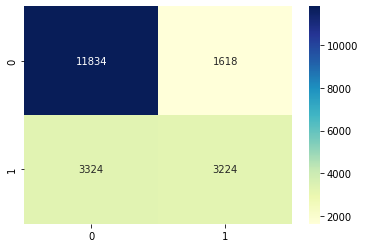

In [9]:
# xgboost 성능 확인
get_clf_eval(y_valid, y_pred_xgb)


정확도: 0.7477
정밀도: 0.6129
재현율: 0.6226
AUC: 0.7156
F1: 0.6177


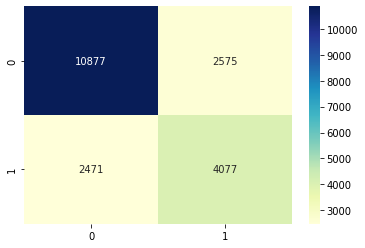

In [15]:
# threshold 변경 및 성능 확인
get_clf_eval(y_valid, y_pred_prob[:,1]>0.4)

In [16]:
lgbm_clf = LGBMClassifier(n_estimators=300,
                          min_child_samples = 20,
                          max_depth = -1,
                          learning_rate = 0.1,
                          num_leaves = 100,
                          reg_lambda = 100,
                          reg_alpha = 0.01,
                          eval_metric='mlogloss'
                          )

In [17]:
knn_clf = KNeighborsClassifier(n_neighbors = 1,
                               weights = 'distance',
                               metric = 'manhattan')

In [18]:
rnd_clf = RandomForestClassifier()
# lgbm_clf = LGBMClassifier()
rid_clf = RidgeClassifier()
dtc_clf = DecisionTreeClassifier()
svm_clf = SVC()
ada_clf = AdaBoostClassifier()
gbc_clf = GradientBoostingClassifier()
bag_clf = BaggingClassifier()
ext_clf = ExtraTreesClassifier()
# knn_clf = KNeighborsClassifier()
svc_clf = SVC()


정확도: 0.7595
정밀도: 0.6691
재현율: 0.5250
AUC: 0.6993
F1: 0.5884


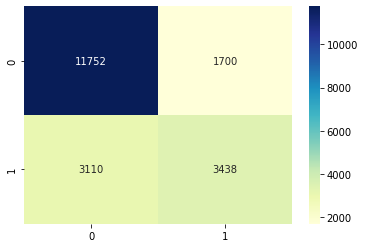

In [19]:
stacking_clf = StackingClassifier(estimators=[('rnd', rnd_clf), ('lgbm', lgbm_clf), ('xgb', xgb_clf),("rid",rid_clf),("knn",knn_clf)], final_estimator = LGBMClassifier())
stacking_clf.fit(X_train, y_train)
y_pred_stack = stacking_clf.predict(X_valid)

# ensemble(stacking) 성능 확인
get_clf_eval(y_valid, y_pred_stack)

In [20]:
# 제출 양식 다운로드
submit = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')

# prediction 수행
df_test = pd.read_csv('/content/drive/MyDrive/test.csv')
submit['answer'] = stacking_clf.predict(df_test.drop(columns=['ID']))

# 제출 파일 저장
submit.to_csv('/content/drive/MyDrive/prediction25.csv', index=False)